In statistical modeling, regression analysis is a set of statistical processes for estimating the relationships between a dependent variable and one or more independent variables. The most common form of regression analysis is linear regression, in which a we finds the line that most closely fits the data according to a specific mathematical criterion.

For this project we are provided with data from two separate sources. The first file contains financial characteristics of firms from the Compustat Annual Industrial file with various factors such as at = Total Assets; act = Current Assets; lct = liabalities, etc) from years 2009 to 2019. The second file contains audit fee information from the Audit Analytics database from years 2009 to 2019. We will use Exploratory Data Analysis (EDA) and Regression analysis on what characteristics/factors are best in explaining the variation in Audit Fees of a company, individualy and all together. 

To understand Audit fees, we should know what an audit means. An audit is a systematic and independent examination of books, accounts, statutory records, documents and vouchers of an organization to ascertain how far the financial statements as well as non-financial disclosures present a true and fair view of the concern. The amount of fees paid to external auditors is of great importance to the stakeholders and that is why disclosure practices requires that such information shall be disclosed in the financial statements of companies. While the determinants of audit fees are not new in literature, the significance of the determinants in pricing audit fees context is limited. 

Hence, this project reviews various factors pertaining to determinants of audit fees and an insight into those determinants of audit fees.

In [317]:
#importing various packages as required
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as sm

DATA ACQUISITION, CLEANING AND MERGING

In [318]:
#imported Factors & Audit fees data
df_factors = pd.read_csv("C:/Users/ishak/Desktop/MS CF/Spring 2020/BANA.680.01 - Data Mgmt for Business Anlyts/Project 4/Compustat.csv")
df_fees = pd.read_csv("C:/Users/ishak/Desktop/MS CF/Spring 2020/BANA.680.01 - Data Mgmt for Business Anlyts/Project 4/Auditfees.csv", encoding='ISO-8859-1')

In [319]:
#dropping unnecesary columns from both the data sets
df_factors = df_factors.drop(columns = ['gvkey', 'datadate', 'indfmt', 'consol', 'popsrc', 'datafmt','conm', 'curcd',
                                        'exchg', 'costat', 'fic', 'emp'])
df_fees = df_fees.drop(columns = ['FISCAL_YEAR_ENDED', 'AUDITOR_NAME', 'COMPANY_FKEY'])

#Renamed a few columns of Audit fees file to successfully merge to compustat file
df_fees.rename(columns = {'FISCAL_YEAR': 'fyear', 'BEST_EDGAR_TICKER' :'tic'},inplace =True) 

#merging data of both the dataset files
df_final1 = pd.merge(df_fees, df_factors, on= ['tic', 'fyear'], how = 'left') #left join on tic

# Removing rows containing null values for both tic and fyear
df_final1 = df_final1.dropna(subset=['tic', 'fyear'])

EXPLORATORY DATA ANALYSIS & DESCRIPTIVE STATISTICS

Understanding the data provided

In [320]:
df_final1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59238 entries, 1 to 640703
Data columns (total 11 columns):
fyear         59238 non-null int64
AUDIT_FEES    59238 non-null int64
tic           59238 non-null object
act           33842 non-null float64
at            48385 non-null float64
ceq           48293 non-null float64
ebit          41516 non-null float64
ebitda        40105 non-null float64
invt          43355 non-null float64
lct           33927 non-null float64
pifo          15410 non-null float64
dtypes: float64(8), int64(2), object(1)
memory usage: 5.4+ MB


Next step would be to remove the columns with more than 30% threshold null values. 

In [321]:
#drop columns with atleast 20% null values
columns_with_atleast_70_percent_non_NA_values = [column for column in df_final1 if df_final1[column].count() / len(df_final1) >= 0.7]
print(columns_with_atleast_70_percent_non_NA_values)

['fyear', 'AUDIT_FEES', 'tic', 'at', 'ceq', 'ebit', 'invt']


In [322]:
columns_to_be_dropped = []
for c in df_final1.columns:
    if c not in columns_with_atleast_70_percent_non_NA_values:
        columns_to_be_dropped.append(c)

print(f'Columns that can be dropped={columns_to_be_dropped}')

#column dropped
df_final1 = df_final1.drop(columns = 'pifo')

Columns that can be dropped=['act', 'ebitda', 'lct', 'pifo']


Here columns 'act', 'ebitda', 'lct', 'pifo' have more than 30% null values but 'act', 'ebitda', 'lct' being an important factor contributing the Audit Fees from Business Understanding, therefore I am not removing the same. I removed 'pifo' as it has 74% null values.
Also referred to: THE DETERMINANTS OF AUDIT FEES AN ANALYTICAL STUDY; WAFAA ABDEL MAGID RAMZY; 1988 (https://www.ros.hw.ac.uk/bitstream/handle/10399/1006/Ramzy_1988.pdf?sequence=1&isAllowed=y)

In [323]:
df = df_final1

count       59238.000000
mean      2122629.651845
std       5967950.061745
min             0.000000
25%         98046.250000
50%        495000.000000
75%       1641327.500000
max     144500000.000000
Name: AUDIT_FEES, dtype: float64


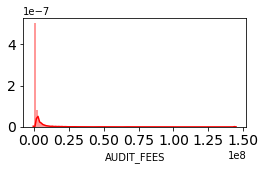

In [324]:
#Plotted Distribution of Audit Fees.
with pd.option_context('float_format', '{:f}'.format): print(df['AUDIT_FEES'].describe()) #Describing the Data Mean, Count etc
plt.figure(figsize=(4,2))
sns.distplot(df['AUDIT_FEES'], color='red', bins=100, hist_kws={'alpha': 0.4})
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14)
plt.show()

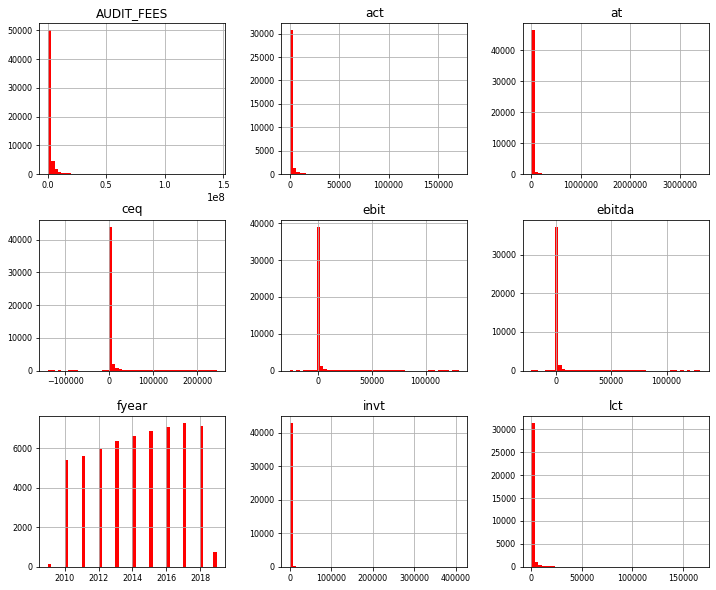

In [325]:
#plotting the distribution of other factors
list(set(df.dtypes.tolist()))
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.hist(figsize=(12, 10), bins=50, color='red', xlabelsize=8, ylabelsize=8)
plt.show()

Understanding above the distribution of Numeric Data to visually interpret that Current Assets, Total Assets, Total Common Equity, EBIT and EBITDA have similar distribution as that of Audit Fees and therefore we can make a guess that they might be the highly correlated factors. To be sure of this, we calculate the Correlation and regression further on the above factors.

In [306]:
#finding the correlation of the factors with Audit fees
df_num_corr = df_num.corr()['AUDIT_FEES']
print(df_num_corr,'\n') #Found Correlation of all Numeric Variables
golden_features_list = df_num_corr[abs(df_num_corr) > 0.6].sort_values(ascending=False)
print("There are {} strongly correlated values with 'Audit Fees':\n{}".
format(len(golden_features_list), golden_features_list))

fyear         0.016478
AUDIT_FEES    1.000000
act           0.726964
at            0.697098
ceq           0.698290
ebit          0.607688
ebitda        0.651015
invt          0.361974
lct           0.698428
Name: AUDIT_FEES, dtype: float64 

There are 7 strongly correlated values with 'Audit Fees':
AUDIT_FEES    1.000000
act           0.726964
lct           0.698428
ceq           0.698290
at            0.697098
ebitda        0.651015
ebit          0.607688
Name: AUDIT_FEES, dtype: float64


To understand the above data, a correlation greater than 0.8 is generally described as strong, whereas a correlation less than 0.5 is generally described as weak. I shortlisted the factors based on the correlation criteria as 0.6 and I get Top 7 factors which also contains Audit Fees itself. 

Therefore we get Current Assets, Total Assets, Total Common Equity, EBIT and EBITDA as strongly correlated factors and I plot the same below in a scatter plot.

In [308]:
golden_features_list = pd.DataFrame(data=golden_features_list).T

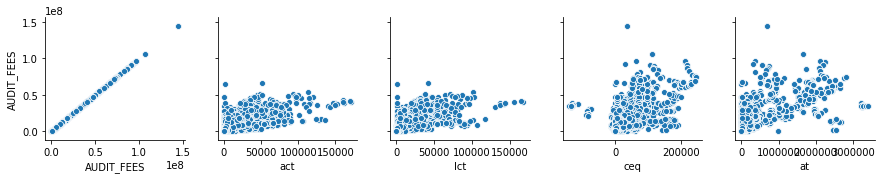

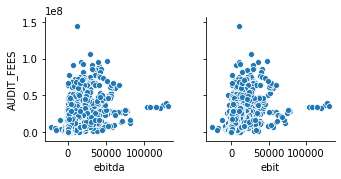

In [309]:
#scatter plot of strongly correlated factors with audit fees
for i in range(0, len(golden_features_list.columns), 5):
    sns.pairplot(data=df_num, 
                 x_vars=golden_features_list.columns[i:i+5], 
                 y_vars=['AUDIT_FEES'])
plt.show()

SUMMARY OF REGRESSIONS

To get our regression equation and regression model, I have used all the 6 shortlisted factors to get the resukts. But before using all of them, I have tested them individually to see how single factor will affect Audit fees. For example I have taken the 2 factors: act & at. Same can be done for each factor.

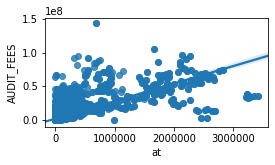

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             AUDIT_FEES   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                 4.574e+04
Date:                Sat, 04 Apr 2020   Prob (F-statistic):               0.00
Time:                        12:05:31   Log-Likelihood:            -8.1083e+05
No. Observations:               48385   AIC:                         1.622e+06
Df Residuals:                   48383   BIC:                         1.622e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1.81e+06   2.11e+04     85.896      0.000    1.77e+06    1.85e+06
at            26.1661      0.122    213.863      0.000      25.926      26.406
==============================================================================
Omnibus:                    47749.162   Durbin-Watson:                   0.256
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12870819.859
Skew:                           4.257   Prob(JB):                         0.00
Kurtosis:                      82.446   Cond. No.                     1.74e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.74e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [315]:
#regression results of current assets and audit fees
fig, ax = plt.subplots(1, 1, figsize = (4, 2))
sns.regplot(x='at',y='AUDIT_FEES',
            data=df_num, ax=ax)
result = sm.ols(formula ="AUDIT_FEES ~ at", data = df_num).fit()
plt.show()
result.summary()

To understand the above results we should know the concept first. R-squared i.e the coefficient of Determination is the proportion of the variance in the dependent variable that is predictable from the independent variable. R-squared is a goodness-of-fit measure for linear regression models. This statistic indicates the percentage of the variance in the dependent variable that the independent variables explain collectively. The variable “total assets” is the most widely used to measure company size. Joshi and AL‐Bastaki (2000) mention several authors who concluded that client size is the most significant variable to explain fees. In turn, Brinn et al. (1994) indicate that clients’ size and complexity were the most significant factors to determine audit expenses.
Source :http://www.scielo.br/pdf/rcf/v26n69/en_1808-057x-rcf-26-69-00261.pdf 
        http://www.scielo.br/pdf/rcf/v26n69/en_1808-057x-rcf-26-69-00261.pdf

We conclude using the R-square that the 48.6% of variation in Audit fees can be explained by at i.e Total Assets.

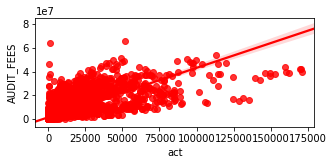

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             AUDIT_FEES   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                 3.793e+04
Date:                Sat, 04 Apr 2020   Prob (F-statistic):               0.00
Time:                        12:05:47   Log-Likelihood:            -5.5181e+05
No. Observations:               33842   AIC:                         1.104e+06
Df Residuals:                   33840   BIC:                         1.104e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.336e+06   1.63e+04     81.833      0.000     1.3e+06    1.37e+06
act          418.3689      2.148    194.750      0.000     414.158     422.579
==============================================================================
Omnibus:                    23442.883   Durbin-Watson:                   0.410
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2147465.500
Skew:                           2.563   Prob(JB):                         0.00
Kurtosis:                      41.687   Cond. No.                     7.83e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [316]:
fig, ax = plt.subplots(1, 1, figsize = (5, 2))
sns.regplot(x='act',y='AUDIT_FEES',
data=df_num, ax=ax, color = "r")
result2 = sm.ols(formula ="AUDIT_FEES ~ act", data = df_num).fit()
plt.show()
result2.summary()

We conclude using the R-squared that the 52.8% of variation in Audit fees can be explained by act i.e Current Assets.

In [314]:
#Regression equation for the Audit fees
result4 = sm.ols(formula ="AUDIT_FEES ~ lct + at + act + ceq + ebitda + ebit", data = df_num).fit()
result4.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             AUDIT_FEES   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     8157.
Date:                Sat, 04 Apr 2020   Prob (F-statistic):               0.00
Time:                        12:03:25   Log-Likelihood:            -5.4006e+05
No. Observations:               33279   AIC:                         1.080e+06
Df Residuals:                   33272   BIC:                         1.080e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1.21e+06   1.53e+04     78.867      0.000    1.18e+06    1.24e+06
lct         -138.8472      7.905    -17.563      0.000    -154.342    -123.352
at           183.1377      2.761     66.324      0.000     177.726     188.550
act          284.2253      6.078     46.761      0.000     272.312     296.139
ceq         -191.7186      4.595    -41.720      0.000    -200.726    -182.711
ebitda      -478.7113     28.899    -16.565      0.000    -535.355    -422.068
ebit         472.2318     29.397     16.064      0.000     414.613     529.851
==============================================================================
Omnibus:                    23476.213   Durbin-Watson:                   0.439
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3084565.523
Skew:                           2.530   Prob(JB):                         0.00
Kurtosis:                      49.893   Cond. No.                     3.01e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.01e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In the above regression results, we conclude using the R-squared that the 59.5% of variation in Audit fees can be explained by our model including 6 independent variables, Current Assets, Total Assets, Total Common Equity, EBIT and EBITDA. There are several studies on factors that determine the audit fees for a company. Audit fee studies, being a tool to assist negotiation between auditors and clients are regularly undertaken all over the world and essentially stem on the factors prevalent in the specific auditing/accounting environments. Using the Correlations and a crosssectional regression model, the results of the analysis above revealed 6 factors as the main determinants of audit fees. However, variables such as emp(employees), gvkey (The Global Company Key) etc appeared to be insignificant determinants of audit fees.

Other determinants significant for audit fees can be the size of a local practice office within an audit firm (hereafter, office size) is a significant, engagement-specific factor determining audit quality and audit fees over and beyond audit firm size at the national level and auditor industry leadership at the city or office level. {Jong-Hag Choi, Chansog (Francis) Kim, Jeong-Bon Kim, and Yoonseok Zang (2010) Audit Office Size, Audit Quality, and Audit Pricing. AUDITING: A Journal of Practice & Theory: May 2010, Vol. 29, No. 1, pp. 73-97.; https://www.aaajournals.org/doi/abs/10.2308/aud.2010.29.1.73}

Moreover as per Mr. Kamal Naser, (https://www.emerald.com/insight/content/doi/10.1108/10569210710833635/full/html) more other factors impacting the Audit fees may be corporate size, status of the audit firm, industry type & degree of corporate complexity and Risk. Client risk has been found to be a significant factor considered in charging audit fees. It can be measured by the following ratios: Current assets to total assets; long-term debt to total assets; income before taxes to total assets (Simon, and Taylor, 2004; Joshi and Al- Bastaki, 2000)(Source: https://www.researchgate.net/publication/321833594_Determinants_of_Audit_fees_in_a_Developing_Economy_Evidence_from_Ghana

To conclude, this analysis and study, studies only a limited number of factors, whereas there are several other factors contributing to the determination of audit fees. Although the factors tested here are significant and cannot be ignored.

Other Sources:
    https://en.wikipedia.org/wiki/Regression_analysis , 
    http://www.businessdictionary.com/definition/audit.html